In [90]:
#pyspark
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *

import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#jupyter dataViz opts

plt.rcParams["figure.figsize"] = [20, 8]

# Prepare dataset :

Dataset downloaded from :

https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis

In [91]:
### Columns description from : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

In [92]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

---

### Clean and prepare Headers :
##### Removing 'Blank space' and replacing it by '_'

In [93]:
#list of headers => list of dictionaries

def entry_dic(line):
    elements = line.split(' - ')
    return {'title': elements[0], 'description': elements[1], 'header': elements[0].lower().replace(' ', '_')}

In [94]:
#Go all over the headers & construct a dictionary 
#Split lines using '\n'

header_dics = list(map(entry_dic, list(filter(lambda l: l != '', content_cols.split('\n')))))

In [95]:
print(header_dics[:2][1]['title'])
#We'll use header, we'll access it using '.'
print(header_dics[:2][1]['header'])

Case Number
case_number


---
### Importing data :


In [96]:
#Loading a data frame from the dataset
df = spark.read.csv('../datasets/*.csv', inferSchema=True, header=True)
df = df.cache()


In [97]:
df.count()

1456714

In [98]:
#Headers of the dataframe
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])
    
#Our features (columns)
allCols = list(df.columns)
allCols

['_c0',
 'id',
 'case_number',
 'date',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

---
#### Identify and clean the dirty columns :


In [99]:
for col in allCols:
    print(col, df.filter((df[col] == "") | df[col].isNull()).count())

## Identify the number of Null | NaN | Empty values in every column

_c0 0
id 0
case_number 1
date 0
block 0
iucr 0
primary_type 0
description 0
location_description 1658
arrest 0
domestic 0
beat 0
district 1
ward 14
community_area 40
fbi_code 0
x_coordinate 37083
y_coordinate 37083
year 0
updated_on 0
latitude 37083
longitude 37083
location 37083


#### Getting rid of a rows without value in 'Location description' 
#### Replacing NaN and Null values with 'U' in all other columns (with a lot of gapes)

---
## Visualizing & Understanding the data

In [100]:
# crime types count
crime_type_groups = df.groupBy('primary_type').count()

#crime localisations count
crime_loc_groups = df.groupBy('location_description').count()

In [101]:
#Order the groups we collected

crime_type_counts = crime_type_groups.orderBy('count', ascending=False)
crime_loc_counts = crime_loc_groups.orderBy('count', ascending=False)

### Crime types

These are the top 20 most frequent crime types:

In [102]:
#Crimes types & localizations in numbers :

#crime_type_counts.show(truncate=False)
#crime_loc_counts.show(truncate=False)

#To sum up :: that's how we can see a summary of the 'trending' crimes by types & by locations

df.groupby('primary_type').count().orderBy('count', ascending=False).show()
df.groupby('location_description').count().orderBy('count', ascending=False).show()

+--------------------+------+
|        primary_type| count|
+--------------------+------+
|               THEFT|329460|
|             BATTERY|263700|
|     CRIMINAL DAMAGE|155455|
|           NARCOTICS|135240|
|             ASSAULT| 91289|
|       OTHER OFFENSE| 87874|
|            BURGLARY| 83397|
|  DECEPTIVE PRACTICE| 75495|
| MOTOR VEHICLE THEFT| 61138|
|             ROBBERY| 57313|
|   CRIMINAL TRESPASS| 36912|
|   WEAPONS VIOLATION| 17233|
|PUBLIC PEACE VIOL...| 13122|
|OFFENSE INVOLVING...| 11398|
|        PROSTITUTION|  7633|
| CRIM SEXUAL ASSAULT|  6823|
|INTERFERENCE WITH...|  6195|
|         SEX OFFENSE|  4885|
|            HOMICIDE|  2649|
|               ARSON|  2217|
+--------------------+------+
only showing top 20 rows

+--------------------+------+
|location_description| count|
+--------------------+------+
|              STREET|330471|
|           RESIDENCE|233530|
|           APARTMENT|185023|
|            SIDEWALK|160891|
|               OTHER| 55774|
|PARKING LOT/G

#### Extracting dictionaries

 Extracting pandas dictionaries from RDD

In [103]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda line: line.asDict()).collect()).head(20)
counts_pddf_loc = pd.DataFrame(crime_loc_counts.rdd.map(lambda line: line.asDict()).collect()).head(20)

In [104]:
counts_pddf.head(10)
counts_pddf_loc.head(10)


,count,location_description
0,330471,STREET
1,233530,RESIDENCE
2,185023,APARTMENT
3,160891,SIDEWALK
4,55774,OTHER
5,41768,PARKING LOT/GARAGE(NON.RESID.)
6,31771,ALLEY
7,30645,RESIDENTIAL YARD (FRONT/BACK)
8,28803,SMALL RETAIL STORE
9,25959,"SCHOOL, PUBLIC, BUILDING"


[Text(0,0.5,'Primary Type'), Text(0.5,0,'Crimes Record Count')]

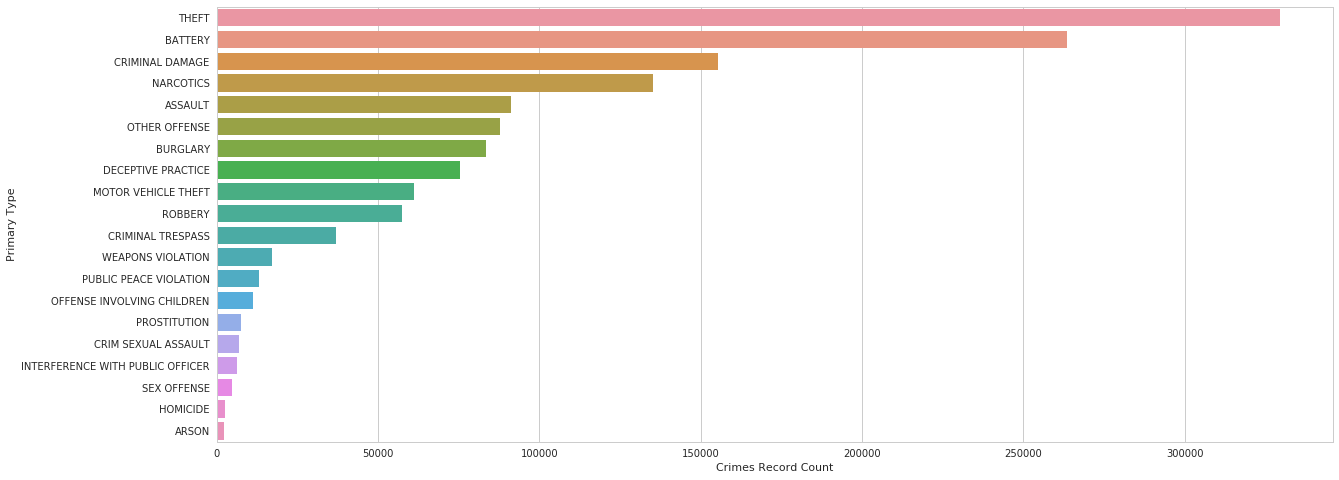

In [105]:
## Just some seaborn params for a better view
sns.set(style="whitegrid")
sns.set_color_codes("dark")

type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

#Visualizing data records by primary type and their count

[Text(0,0.5,'location description'), Text(0.5,0,'Crimes Record Count')]

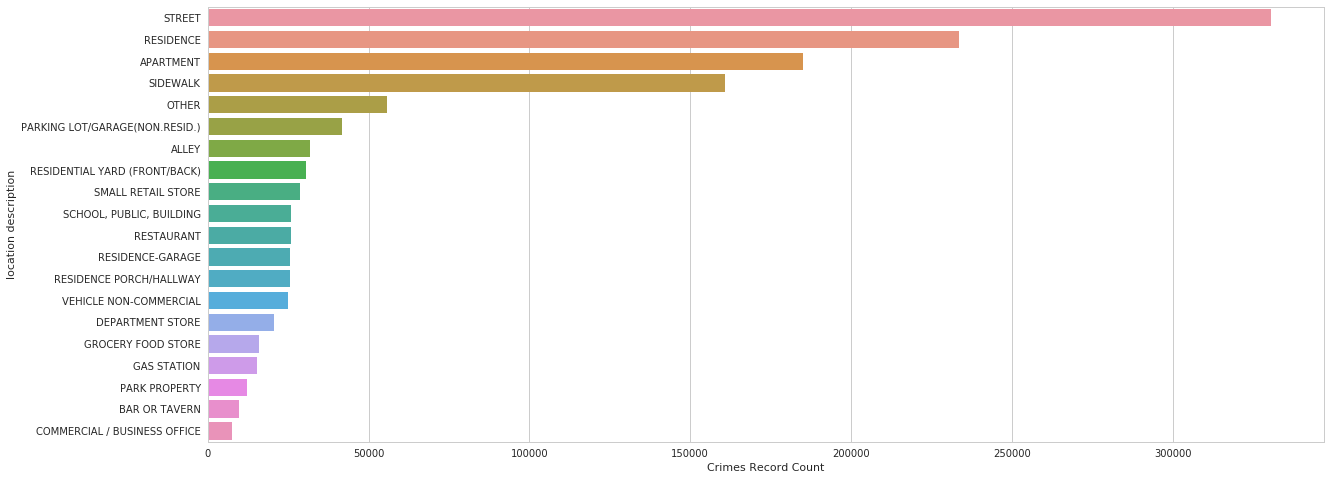

In [106]:
type_graph = sns.barplot(x='count', y='location_description', data=counts_pddf_loc)
type_graph.set(ylabel="location description", xlabel="Crimes Record Count")

#Visualizing data records by primary type and their count

### Recorded Date

In [107]:
df.select(min('date').alias('first_rec'), max('date').alias('last_rec')).show(truncate=False)
df.select((datediff(to_date(max('date'), "MM/dd/yyyy"), to_date(min('date'), "MM/dd/yyyy"))/365).alias('duration')).show()

+----------------------+----------------------+
|first_rec             |last_rec              |
+----------------------+----------------------+
|01/01/2012 01:00:00 AM|12/31/2016 12:56:00 AM|
+----------------------+----------------------+

+-----------------+
|         duration|
+-----------------+
|5.002739726027397|
+-----------------+



---
#### Prepare dates for stats viewing :

###### We will prepare dates columns in order to facilitate data viswualisation based on dates:
###### Convert dates from string to Timestamp + add columns


In [108]:
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', trunc('date_time', 'MM'))\
       .withColumn('year', trunc('date_time', 'yyyy'))

### Statistics based on dates

In [109]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month']).count().orderBy(['count'], ascending=[True, False])
type_arrest_date = type_arrest_date.dropna()
type_arrest_date.show(4, truncate=False)

+------+----------+-----+
|arrest|month     |count|
+------+----------+-----+
|true  |2017-01-01|1902 |
|true  |2016-12-01|3088 |
|true  |2016-11-01|3385 |
|true  |2016-10-01|3783 |
+------+----------+-----+
only showing top 4 rows



In [110]:
# locations of crimes and arrest over years:
loc_arrest_date = df.groupBy(['arrest','location_description', 'month']).count().orderBy(['count'], ascending=[True, False])
loc_arrest_date = loc_arrest_date.dropna()
loc_arrest_date.show(3, truncate=False)

+------+------------------------------+----------+-----+
|arrest|location_description          |month     |count|
+------+------------------------------+----------+-----+
|true  |ATM (AUTOMATIC TELLER MACHINE)|2013-03-01|1    |
|true  |BRIDGE                        |2013-08-01|1    |
|true  |AIRPORT EXTERIOR - SECURE AREA|2012-03-01|1    |
+------+------------------------------+----------+-----+
only showing top 3 rows



In [111]:
## Construct a pandas DF from the collected dictionary of the RDD
temp_type_arrest_date = type_arrest_date
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

## Add a column for Year & column for Month's name
## We also should drop NaN values 

type_arrest_pddf = type_arrest_pddf.dropna()
type_arrest_pddf['yearcr'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))
#type_arrest_pddf['monthcr'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%m'))
type_arrest_pddf['monthName'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%b'))

In [112]:
type_arrest_pddf.head(5)

,arrest,count,month,yearcr,monthName
0,True,1902,2017-01-01,2017,Jan
1,True,3088,2016-12-01,2016,Dec
2,True,3385,2016-11-01,2016,Nov
3,True,3783,2016-10-01,2016,Oct
4,True,3831,2016-09-01,2016,Sep


In [113]:
# Data for plotting

arrest_by_year = type_arrest_pddf[['yearcr', 'count', 'arrest']].copy()

## Let's filter all False Arrests => we have all True arrests
indexNames = arrest_by_year[ arrest_by_year['arrest'] == False ].index

# Delete these row indexes from dataFrame
arrest_by_year.drop(indexNames , inplace=True)

## Same for False arrests
notarrest_by_year = type_arrest_pddf[['yearcr', 'count', 'arrest']].copy()

## Let's filter all True Arrests => we have all False arrests
indexNames = notarrest_by_year[ notarrest_by_year['arrest'] == True ].index

# Delete these row indexes from dataFrame
notarrest_by_year.drop(indexNames , inplace=True)

arrest_by_year.head(5)

,yearcr,count,arrest
0,2017,1902,True
1,2016,3088,True
2,2016,3385,True
3,2016,3783,True
4,2016,3831,True


In [114]:
notarrest_by_year.head(5)

,yearcr,count,arrest
61,2017,9455,False
62,2015,11162,False
63,2014,12178,False
64,2014,14170,False
65,2016,14442,False


In [115]:
arrest_by_year = arrest_by_year.groupby(['yearcr']).sum()
notarrest_by_year = notarrest_by_year.groupby(['yearcr']).sum()

### Now we have Crimes over all the years and also their status = Arrest / No arrest

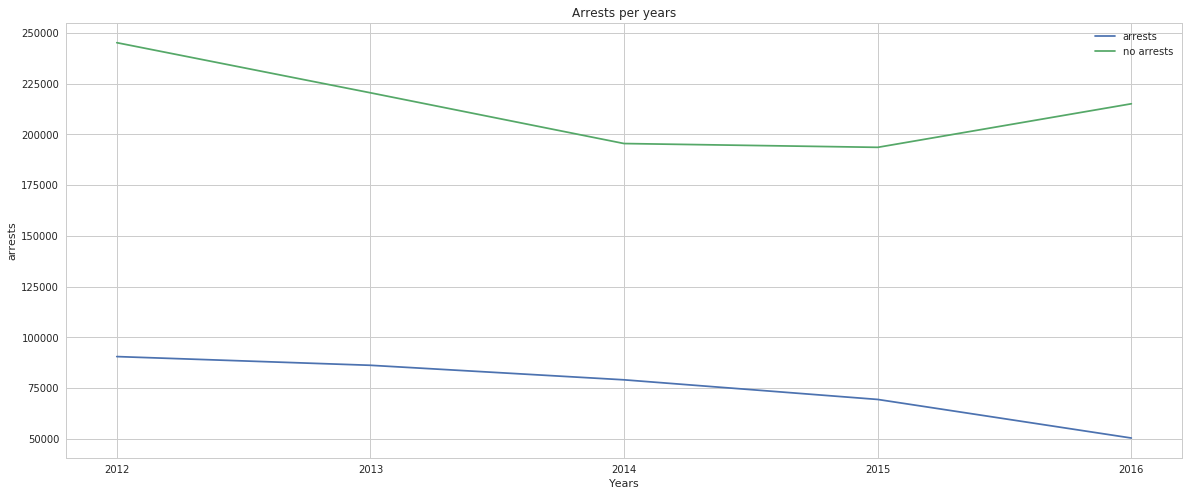

In [116]:
## Let's view those arrests by years 

fig, ax = plt.subplots()
months = ['2012','2013','2014','2015', '2016']
ax.plot(months, arrest_by_year['count'].drop('2017'), label='arrests')
ax.plot(months, notarrest_by_year['count'].drop('2017'), label='no arrests')

ax.set(xlabel='Years', ylabel='arrests',title='Arrests per years')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Distance between Arrests & Non-arrests increased between 2015 & 2016

#### Add column for hourly based analysis

In [117]:
df_hour = df.withColumn('hour', hour(df['date_time']))

## Clean data
df_hour = df_hour.dropna()

## Count crimes by hours & types
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_count.show(5)

+-----------------+----+-----+
|     primary_type|hour|count|
+-----------------+----+-----+
|WEAPONS VIOLATION|  23| 1228|
|        OBSCENITY|  14|    7|
|        OBSCENITY|  11|    7|
|          ROBBERY|  14| 2340|
|      SEX OFFENSE|  18|  220|
+-----------------+----+-----+
only showing top 5 rows



In [118]:
## Regroup crimes by hours and sum number of crimes we counted

hourly_total_count = hourly_count.groupBy('hour').sum('count')
hourly_total_count.show()

+----+----------+
|hour|sum(count)|
+----+----------+
|  12|     80695|
|  22|     74581|
|   1|     42954|
|  13|     67802|
|   6|     23834|
|  16|     74338|
|   3|     30447|
|  20|     79262|
|   5|     19758|
|  19|     82454|
|  15|     78011|
|   9|     64571|
|  17|     73841|
|   4|     22840|
|   8|     48842|
|  23|     60217|
|   7|     33667|
|  10|     62989|
|  21|     75164|
|  11|     65280|
+----+----------+
only showing top 20 rows



In [119]:
## Create a pandas dataframe from hourly_data_count
collected_dict = hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'])\
                                .rdd.map(lambda l: l.asDict())\
                                .collect()

hourly_count_pddf = pd.DataFrame(collected_dict).sort_values(by='hour')

hourly_count_pddf.head(5)

,hour,sum(count)
22,0,67602
2,1,42954
21,2,36774
6,3,30447
13,4,22840


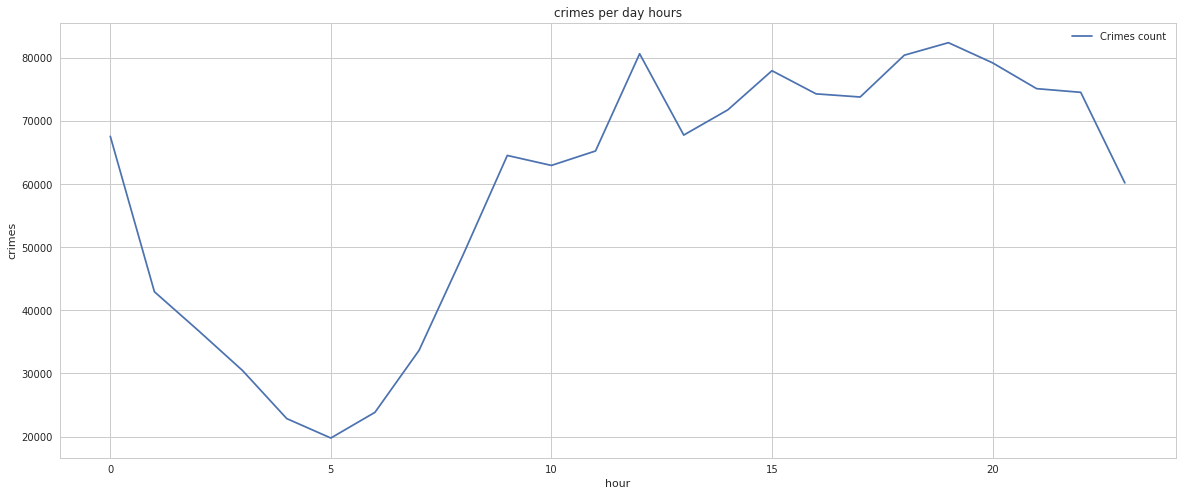

In [120]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['sum(count)'], label='Crimes count')

ax.set(xlabel='hour', ylabel='crimes', title='crimes per day hours')
ax.grid(b=True, which='y', axis='y')
ax.legend()

In [121]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [122]:
from ipyleaflet import Map, Marker, Icon

chicago = (41.8781136, -87.62979819999998)
ChicagoCity=Map(center = chicago, zoom = 13)

In [123]:
crime_localisation = df.groupBy(['latitude' , 'longitude', 'primary_type']).count()

In [124]:
localisation = pd.DataFrame(crime_localisation.rdd.map(lambda l: l.asDict()).collect())#.head(100)

In [125]:
icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[19, 47], icon_anchor=[11,46])
for count, lat, long, crime in localisation.itertuples(index=False):
    if count  > 50:
        marker = Marker(location=(lat , long), draggable=False, title=crime, rise_on_hover=True, icon=icon, rotation_origin='11px 46px')
        ChicagoCity.add_layer(marker);

ChicagoCity    

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Prediction pattern

In [126]:
import numpy as np
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, StringType, ArrayType

In [127]:
# Make some fake data and train a model.
n_samples_test = 100000
n_samples_train = 1000
n_samples_all = n_samples_train + n_samples_test
n_features = 50

X, y = make_classification(n_samples=n_samples_all, n_features=n_features, random_state=123)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=n_samples_test, random_state=45)

# Use pandas to put the test data in parquet format to illustrate how to load it up later.
# In real usage, the data might be on S3, Azure Blog Storage, HDFS, etc.
column_names = [f'feature{i}' for i in range(n_features)]
(
    pd.DataFrame(X_test, columns=column_names)
    .reset_index()
    .rename(columns={'index': 'id'})
    .to_parquet('unlabeled_data')
)

In [128]:
param_grid = {'n_estimators': [100], 'max_depth': [2, 4, None]}
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc'
).fit(X_train, y_train)
print('ROC AUC: %.3f' % gs_rf.best_score_)

ROC AUC: 0.959


In [148]:
# Number of types of location recorded in the dataset
#df.select('location_description').distinct().count()
df_hour.select('location_description', 'hour', 'primary_type').distinct()

+--------------------+----+--------------------+
|location_description|hour|        primary_type|
+--------------------+----+--------------------+
|              STREET|  14|     CRIMINAL DAMAGE|
|RESIDENCE PORCH/H...|   9|               THEFT|
|              STREET|   8|             BATTERY|
|              STREET|  15|             BATTERY|
|            SIDEWALK|  20|LIQUOR LAW VIOLATION|
|         GAS STATION|   3|               THEFT|
|    DEPARTMENT STORE|  20|               THEFT|
|PARKING LOT/GARAG...|   6|             BATTERY|
|           APARTMENT|  23|       OTHER OFFENSE|
|             TAXICAB|   1|  DECEPTIVE PRACTICE|
|   CURRENCY EXCHANGE|   5|  DECEPTIVE PRACTICE|
|COMMERCIAL / BUSI...|  17|               THEFT|
|RESIDENCE PORCH/H...|  21|     CRIMINAL DAMAGE|
|              STREET|  15|   CRIMINAL TRESPASS|
|           CTA TRAIN|  11|             ROBBERY|
|              STREET|  15|   WEAPONS VIOLATION|
|COMMERCIAL / BUSI...|  16|             BATTERY|
|HOSPITAL BUILDING..

In [150]:
location_hour = pd.DataFrame(df_hour.select('location_description', 'hour', 'primary_type').distinct().rdd.map(lambda l: l.asDict()).collect())
location_hour

AttributeError: 'int' object has no attribute 'rdd'

In [142]:
#Being on the street and at home
street_home_hour = location_hour.where((location_hour['location_description'] == 'STREET') | (location_hour['location_description'] == 'RESIDENCE')).dropna()

In [ ]:
domestic_hour = pd.DataFrame(df_hour.groupBy(['domestic', 'hour']).count().orderBy('hour').rdd.map(lambda row: row.asDict()).collect())

In [ ]:

dom = domestic_hour[domestic_hour['domestic'] == 'True']['count']
non_dom = domestic_hour[domestic_hour['domestic'] == 'False']['count']

either_dom = domestic_hour.groupby(by=['hour']).sum()['count']

dom_keys = domestic_hour[domestic_hour['domestic'] == 'False']['hour']

In [ ]:
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [ ]:

df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

In [ ]:
week_day_crime_counts = df_dates.groupBy('week_day').count()
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
year_month_crime_counts = df_dates.groupBy('year_month').count()
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
month_day_crime_counts = df_dates.groupBy('month_day').count()
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

In [ ]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

In [ ]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

In [ ]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

In [ ]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [ ]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [ ]:
top_crime_types_lst

In [ ]:
top_busy_areas_lst

In [ ]:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"
print(q1)

In [ ]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [ ]:
df_dates_tops.count()

In [ ]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [ ]:
tops_of_tops.show(20)

In [ ]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [ ]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [ ]:
code_pairs[:5]

In [ ]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [ ]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [ ]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

In [ ]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [ ]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [ ]:
named_tops_of_tops.show(10)

In [ ]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

In [ ]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')

In [ ]:
selected_features = [
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [ ]:
#Let's see the schema of these selected features:
features_df = df_dates.select(selected_features)
features_df.printSchema()

In [ ]:
feature_level_count_dic = []

for feature in selected_features:
    print('Analysing %s' % feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})

In [ ]:
pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

##The model

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
df_dates_features = df_dates.na.drop(subset=selected_features)

In [ ]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

In [ ]:
## String-index the response variable:
response_indexer = StringIndexer(inputCol='primary_type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)

In [ ]:
#What does it look like now...
df_dates_features.show(1)

In [ ]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

In [ ]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

In [ ]:
vectorized_df_dates.select('features').take(1)